In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from numpy.linalg import norm
from numpy.linalg import solve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import LinearOperator
from matplotlib.colors import LogNorm

from modules.armijo import *
from modules.nlcgm import fr, pr
from modules.newton import nm, fd_nm, inm
from modules.nelme import nelmead
from modules.steep import sd

In [2]:
x = np.array([[1.2], [1.2]])
machine_eps = np.finfo(type(x[0, 0])).eps

print(f"Machine precision: {machine_eps}")

Machine precision: 2.220446049250313e-16


In [3]:
np.set_printoptions(precision=int(np.ceil(np.abs(np.log10(machine_eps)))+1))

# Unconstrained optimization
Test some well-known optimization methods discussed during the course:
* Steepest descent
* Newton method (also with finite difference approximation)
* Non-linear conjugate gradient method (both Fletcher-Reeves and Polak-Ribière)
* Inexact Newton method
* Nelder-Mead

## Test on Rosenbrock function

In [4]:
def f_test(x):
    if not x.shape == (2, 1):
        x = x.reshape((-1, 1))
        
    return (100 * (x[1, :] - x[0, :]**2)**2 + (1 - x[0, :])**2)[0]


def gradf_test(x):
    if not x.shape == (2, 1):
        x = x.reshape((-1, 1))
        
    return np.array([[(200 * (x[1, :] - x[0, :]**2) * (-2 * x[0, :]) - 2 * (1 - x[0, :]))[0]],
                    [(200 * (x[1, :] - x[0, :]**2))[0]]])
    
def hessf_test(x):
    if not x.shape == (2, 1):
        x = x.reshape((-1, 1))
        
    return np.array([[(1200 * x[0, :]**2 - 400 * x[1, :] + 2)[0], (-400 * x[0, :])[0]],
                    [(-400 * x[0, :])[0], 200]])
    
def fd_gradf_test(x, f=f_test):
    if not x.shape == (2, 1):
        x = x.reshape((-1, 1))
        
    global machine_eps
    h = norm(x) * np.sqrt(machine_eps)

    grad = np.zeros(x.shape)

    for i in range(x.shape[0]):
        ei = np.zeros(x.shape)
        ei[i, :] = 1
        grad[i, :] = (f(x + h * ei) - f(x - h * ei)) / (2 * h)

    return grad
        
def fd_hessf_test(x, f=f_test):
    if not x.shape == (2, 1):
        x = x.reshape((-1, 1))
        
    global machine_eps
    h = norm(x) * np.sqrt(machine_eps) * 10

    hess = np.zeros([x.shape[0], x.shape[0]])

    fis = []
    for i in range(x.shape[0]):
        ei = np.zeros(x.shape)
        ei[i, :] = 1
        fis.append(f(x + h * ei))

    for i in range(x.shape[0]):
        for j in range(i, x.shape[0]):
            ei = np.zeros(x.shape)
            ei[i, :] = 1
            ej = np.zeros(x.shape)
            ej[j, :] = 1

            hess[i, j] = (f(x + h * (ei + ej)) - fis[i] - fis[j] + f(x)) / (h**2)
            hess[j, i] = hess[i, j]

    return hess

In [5]:
tol_test = 1e-8

### The function itself

In [6]:
xmin, xmax, xstep = -2, 4, .05
ymin, ymax, ystep = -2, 4, .05

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [7]:
z = np.empty(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = f_test(np.array([[x[i, j]], [y[i, j]]]))

In [8]:
xymin = np.array([[1], [1]])
zmin = np.array([0])

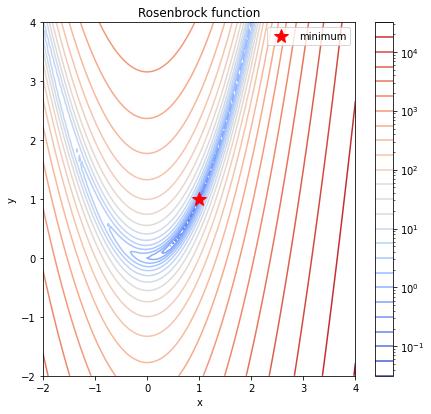

In [9]:
fig, ax = plt.subplots(figsize=(7, 6.5))

ax.set_title("Rosenbrock function")

cp = ax.contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
fig.colorbar(cp, ticks=[1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
ax.plot(*xymin, 'r*', markersize=15, label="minimum")


ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.savefig("rosenbrock.pdf", bbox_inches="tight")

## Steepest descent

In [10]:
start = time.time()
t = sd(f_test, gradf_test, np.array([[-1.2], [1]]), max_iter=20000, tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999921870267 0.9999999843587865]]
Function value in the solution: 6.106585979002317e-17
Gradient norm in the solution: 9.996831009061976e-09
Iterations needed to reach the solution: 19435


In [11]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 2639.1836212182516


In [12]:
path = t[0]

sd_x, sd_y = [], []
for p in path:
    sd_x.append(p[0])
    sd_y.append(p[1])

## Newton method

In [13]:
start = time.time()
t = nm(f_test, gradf_test, hessf_test, np.array([[-1.2], [1]]), tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999999400667 0.9999999998789006]]
Function value in the solution: 3.743975643139474e-21
Gradient norm in the solution: 4.473328123560842e-10
Iterations needed to reach the solution: 21


In [14]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 5251.006557767974


In [15]:
path = t[0]

nm_x, nm_y = [], []
for p in path:
    nm_x.append(p[0])
    nm_y.append(p[1])

### With finite difference approximation

In [16]:
start = time.time()
t = fd_nm(f_test, fd_gradf_test, fd_hessf_test, np.array([[-1.2], [1.0]]), tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999999475664 0.9999999998951064]]
Function value in the solution: 2.7493535920880065e-21
Gradient norm in the solution: 9.42234400941569e-11
Iterations needed to reach the solution: 21


In [17]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 2625.0337962687013


In [18]:
path = t[0]

nmfd_x, nmfd_y = [], []
for p in path:
    nmfd_x.append(p[0])
    nmfd_y.append(p[1])

## Non-linear conjugate gradient method
### Fletcher-Reeves

In [19]:
start = time.time()
t = fr(f_test, gradf_test, np.array([[-1.2], [1]]), alpha_0=5, tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999889068951 0.9999999777697023]]
Function value in the solution: 1.2325135162026487e-16
Gradient norm in the solution: 9.922789617444982e-09
Iterations needed to reach the solution: 237


In [20]:
print(f"It. per second: {t[2]/ (end - start)}")

It. per second: 1884.7409047817678


In [21]:
path = t[0]

fr_x, fr_y = [], []
for p in path:
    fr_x.append(p[0])
    fr_y.append(p[1])

### Polak & Ribière

In [22]:
start = time.time()
t = pr(f_test, gradf_test, np.array([[-1.2], [1]]), alpha_0=5, tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999998353678 0.9999999996876836]]
Function value in the solution: 5.582722573073307e-20
Gradient norm in the solution: 7.875255172857949e-09
Iterations needed to reach the solution: 153


In [23]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 930.323115262449


In [24]:
path = t[0]

pr_x, pr_y = [], []
for p in path:
    pr_x.append(p[0])
    pr_y.append(p[1])

## Inexact Newton Method

In [25]:
start = time.time()
t = inm(f_test, gradf_test, hessf_test, np.array([[-1.2], [1]]), tp="suplin", tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [[0.9999999999644995 0.9999999999288541]]
Function value in the solution: 1.2623840325357688e-21
Gradient norm in the solution: 3.1778754833836855e-11
Iterations needed to reach the solution: 21


In [26]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 1750.4398736063913


In [27]:
path = t[0]

inm_x, inm_y = [], []
for p in path:
    inm_x.append(p[0])
    inm_y.append(p[1])

## Nelder & Mead

In [28]:
start = time.time()
t = nelmead(f_test, np.array([[-1.2], [1]]), tol=tol_test)
end = time.time()

Starting point: [[-1.2  1. ]]
Solution point: [1.0000000013687078 1.0000000026635865]
Function value in the solution: 2.418435639945496e-18
Iterations needed to reach the solution: 148


In [29]:
print(f"It. per second: {t[2] / (end - start)}")

It. per second: 9228.803235062367


In [30]:
S_seq = t[0]

for i in range(len(S_seq)):
    xs = []
    ys = []
    for p in S_seq[i]:
        xs.append(p[0])
        ys.append(p[1])
    xs.append(xs[0])
    ys.append(ys[0])
    S_seq[i] = (xs, ys)

## Plots

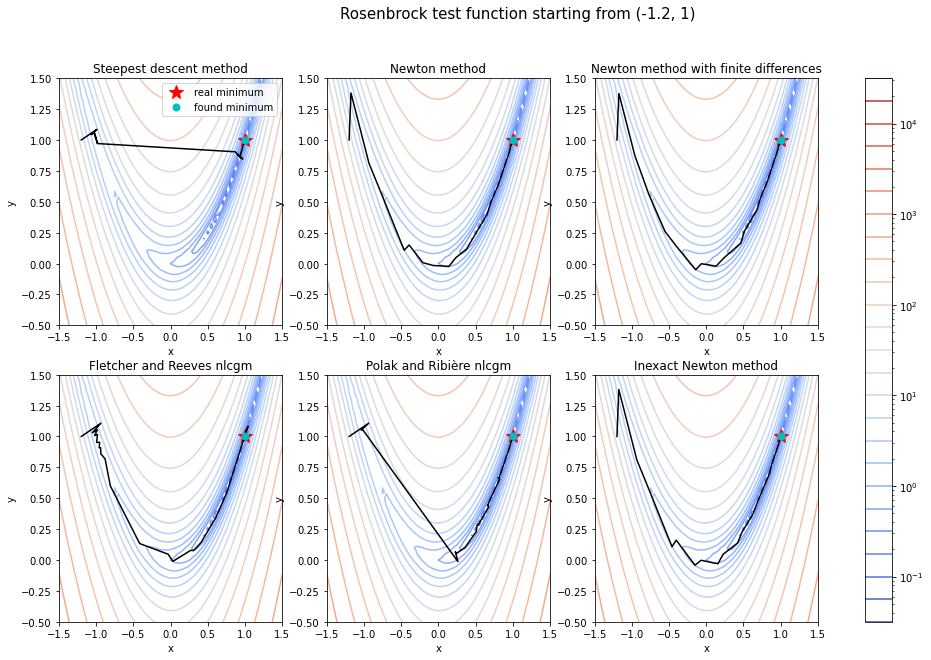

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(17, 10))
plt.suptitle("Rosenbrock test function starting from (-1.2, 1)", fontsize=15, fontweight="medium")

ax[1][0].set_title("Fletcher and Reeves nlcgm")
ax[1][1].set_title("Polak and Ribière nlcgm")
ax[0][1].set_title("Newton method")
ax[0][2].set_title("Newton method with finite differences")
ax[1][2].set_title("Inexact Newton method")
ax[0][0].set_title("Steepest descent method")

cb = ax[1][0].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
ax[1][1].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
ax[0][1].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
ax[0][2].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
ax[1][2].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
ax[0][0].contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)

for i in ax:
    for a in i:
        a.set_xlabel("x")
        a.set_ylabel("y")
        a.plot(*xymin, 'r*', markersize=15, label="real minimum")
        a.set_xlim([-1.5, 1.5])
        a.set_ylim([-0.5, 1.5])
        
ax[1][0].plot(fr_x, fr_y, "k")
ax[1][0].plot(fr_x[-1], fr_y[-1], 'co', markersize=7, label="found minimum")
ax[1][1].plot(pr_x, pr_y, "k")
ax[1][1].plot(pr_x[-1], pr_y[-1], 'co', markersize=7, label="found minimum")
ax[0][1].plot(nm_x, nm_y, "k")
ax[0][1].plot(nm_x[-1], nm_y[-1], 'co', markersize=7, label="found minimum")
ax[0][2].plot(nmfd_x, nmfd_y, "k")
ax[0][2].plot(nmfd_x[-1], nmfd_y[-1], 'co', markersize=7, label="found minimum")
ax[1][2].plot(inm_x, inm_y, "k")
ax[1][2].plot(inm_x[-1], inm_y[-1], 'co', markersize=7, label="found minimum")
ax[0][0].plot(sd_x, sd_y, "k")
ax[0][0].plot(sd_x[-1], sd_y[-1], 'co', markersize=7, label="found minimum")

ax[0][0].legend()
fig.colorbar(cb, ax=ax.ravel().tolist(), ticks=[1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])

plt.plot()

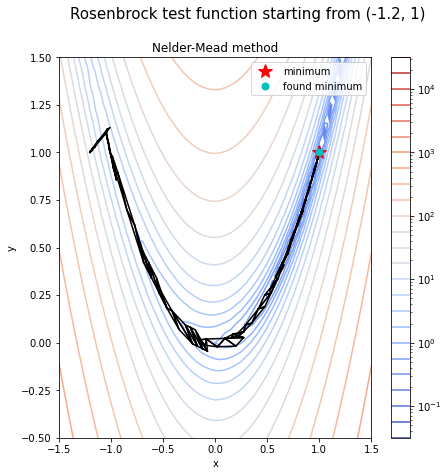

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.suptitle("Rosenbrock test function starting from (-1.2, 1)", fontsize=15, fontweight="medium")
ax.set_title("Nelder-Mead method")

cp = ax.contour(x, y, z, levels=np.logspace(-1.5, 4.5, 25), norm=LogNorm(), cmap=plt.cm.coolwarm)
fig.colorbar(cp, ticks=[1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
ax.plot(*xymin, 'r*', markersize=15, label="minimum")

for (xs, ys) in S_seq:
    ax.plot(xs, ys, "k")
    
xs, ys = S_seq[-1]
ax.plot(xs[-2], ys[-2], 'co', markersize=7, label="found minimum")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-0.5, 1.5])

plt.plot()